### <strong><font color=cornflowerblue>第六次作品：不同元件結構的可靠度分析與模擬 </font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong><font color=lightseagreen>作品目標</font></strong>：
本實驗針對元件連接方式進行可靠度分析，分別模擬元件<font color=indianred>串聯</font>與<font color=indianred>並聯</font>的情況，並採用四種方法估計串聯與並聯後的元件分佈參數，包括「最小平方法（LSM）」、「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」。接著，設計兩套同時包含串聯與並聯的系統：一套採用<font color=indianred>先串聯後並聯</font>的連接方式，另一套則採用<font color=indianred>先並聯後串聯</font>的連接方式。對這兩套系統進行模擬，並同樣使用上述方法估計結合後系統的分佈參數，進一步比較估計結果，並從中判斷出最佳的系統組合方式。

<hr>

#### <strong><font color=indianred>載入套件</font></strong>：

In [1]:
from platform import python_version
import os, time, socket, warnings
from scipy.stats import beta, gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.optimize import minimize
import concurrent.futures

# print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
# print("【工作目錄】{}".format(os.getcwd()))
# print("【主機名稱】{} ({})".format(socket.gethostname(),socket.gethostbyname(socket.gethostname())))
# print("【Python】{}".format(python_version()))

<hr>
<hr>

### <strong><font color=cornflowerblue>目標一</font></strong>：
本目標想要估計出<font color=indianred>串聯元件</font>的 Beta 分佈參數，以下為實驗步驟：

假設兩獨立變數：$X \sim \beta(a_1, b_1)$，$Y \sim \beta(a_2, b_2)$，結合形成一新變數 $Z = XY$，推導後可得其機率密度函數 PDF 為
$$f_{Z}(z) = \int_z^1 f_Y(y)f_X\left(\frac{z}{y}\right) \frac{1}{y} \;dy$$

首先，本實驗想從理論上獲得由上述 $Z$ 的 PDF 近似出的另一個 Beta 分配 $\beta(a, b)$，並估計出其參數，方法為下述的「最小平方法（LSM）」
$$ \min_{\substack{a, b > 0}} \int_{0}^{1} (f_{Z}(z) - \beta(z|a,b))^2 \; dz $$

令 $X$, $Y$ 的 Beta PDF 的參數分別為 $(a_1, b_1)=(6, 3), (a_2, b_2)=(9, 5)$，利用上述方法估計出 $Z$ 的分佈參數 $a, b$。

$\quad$

此外，本實驗假設在無法透過數學推導獲得 $Z$ 的真實 PDF 的情況下，藉由生成 $X$ 與 $Y$ 的隨機樣本，並根據 $Z = XY$ 的關係進行計算，取得 $Z$ 的樣本。接著，分別使用「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」來估計這些樣本的 Beta 分佈參數值，並將結果與理論估計的參數值進行比較，以觀察其差異及與理論值的接近程度，從而選擇最適合的參數估計方法。

- MLE 在 Python 裡可使用的計算方式：
    - 使用 `scipy.optimize.minimize`；

    - 使用 `scipy.optimize.fmin`；

    - 使用 `scipy.stats.beta.fit`，其中 method = 'MLE'。

- MME 在 Python 裡可使用的計算方式：
    - 利用公式直接進行計算：
    $$ a = \bar{x}\left(\frac{\bar{x}(1 - \bar{x})}{s^2} - 1\right) $$
    $$ b = (1 - \bar{x})\left(\frac{\bar{x}(1 - \bar{x})}{s^2} - 1\right) $$

    - 使用 `scipy.stats.beta.fit`，其中 method = 'MM'。

- KDE 在 Python 裡可使用的計算方式：
    - 使用 `scipy.stats.gaussian_kde`。

$\quad$

串聯示意圖：
<!-- ![GitHub Logo](https://raw.githubusercontent.com/shengsia02/StatComp/refs/heads/main/hw6/series_conn.png?token=GHSAT0AAAAAAC2ML3L5FKYG4FKHP73A4WQYZ3FN3DA) -->

<!-- <p align="center">
  <img src="https://raw.githubusercontent.com/shengsia02/StatComp/refs/heads/main/hw6/series_conn.png?token=GHSAT0AAAAAAC2ML3L5UIUE5NJOTJIQVP7GZ3GIGZQ" alt="Series Connection" width="500"/>
</p> -->

<p align="center">
  <img src="fig/series_conn.png" alt="Series Connection" width="500"/>
</p>

**<font color=indianred>Step 1</font>**：由於在計算 LSM 時會使用 `scipy.optimize.minimize` 指令，其中 `method` 裡有許多不同的演算法可供選擇，每種方法的使用條件均不相同，故本實驗嘗試使用所有可用的演算法來進行 LSM 計算，並重複計算 r = 10 次，將估計出的參數 $a, b$ 和計算時間 times 取平均，選出最合適、最快速的演算法來進行後續的實驗。

`scipy.optimize.minimize` 裡的 15 種演算法：

<!-- 1. Unconstrained Minimization of Multivariate Scalar Functions -->

- L-BFGS-B Algorithm (`method = 'L-BFGS-B'`)，預設的 method

- Nelder-Mead Simplex Algorithm (`method = 'Nelder-Mead'`)

- Powell Algorithm (`method = 'Powell'`)

- Broyden-Fletcher-Goldfarb-Shanno Algorithm (`method = 'BFGS'`)

- Newton-Conjugate-Gradient Algorithm (`method = 'Newton-CG'`)

- Trust-Region Newton-Conjugate-Gradient Algorithm (`method = 'trust-ncg'`)

- Trust-Region Truncated Generalized Lanczos / Conjugate Gradient Algorithm (`method = 'trust-krylov'`)

- Trust-Region Nearly Exact Algorithm (`method = 'trust-exact'`)

<!-- 2. Constrained minimization of multivariate scalar functions -->

- Trust-Region Constrained Algorithm (`method = 'trust-constr'`)

- Sequential Least SQuares Programming (SLSQP) Algorithm (`method = 'SLSQP'`)

- Constrained Optimization BY Linear Approximation (COBYLA) Algorithm (`method = 'COBYLA'`)

- Constrained Optimization BY Quadratic Approximations (COBYQA) Algorithm (`method = 'COBYQA'`)

<!-- 3. Other -->

- Conjugate Gradient Algorithm (`method = 'CG'`)；

- Dog-Leg Trust-Region Algorithm (`method = 'dogleg'`)；

- Truncated Newton (TNC) Algorithm (`method = 'TNC'`)

In [2]:
## 初始設定
# 設定參數
a1, b1, a2, b2 = 6, 3, 9, 5
# 設定 X, Y 的分配
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)
# 計算理論 Z 的 PDF
# z = np.linspace(0, 1, 100)
def f(z):
    fxy = lambda y : fy(y) * fx(z / y) / y  # define the integrand: inline
    tmp = integrate.quad(fxy, z, 1)
    return tmp[0]
# fz = np.vectorize(f)(z)  # z 如果是 array，就會自動對每個元素呼叫 f，並且返回一個 array


## 用另一個 Beta 分配 \beta(a,b) 來近似 Z 的分配
# 定義 LSM 函數
def est_beta_param(params):
    a, b = params
    beta_pdf = lambda z: beta.pdf(z, a, b)
    integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
    integral = integrate.quad(integrand, 0, 1)
    return integral[0]
# 初始值
initial = [6, 8]
# 設定邊界
bounds = [(0, np.inf), (0, np.inf)]


## 使用所有演算法來估計參數
# method = 'CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov' 不支持 constraints
methods = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr']
a_hat_avg = np.zeros(len(methods))
b_hat_avg = np.zeros(len(methods))
times_avg = np.zeros(len(methods))
# 重複計算 r 次
r = 10

# for i, method in enumerate(methods):
#     a_hat = np.zeros(r)
#     b_hat = np.zeros(r)
#     times = np.zeros(r)

#     for j in range(r):
#         # 開始時間
#         start_time = time.time()
#         # 使用 minimize 來最小化目標函數
#         result = minimize(est_beta_param, initial, bounds = bounds, method = method)
#         # 結束時間
#         end_time = time.time()
#         # 獲取估計的參數
#         a_hat[j], b_hat[j] = result.x
#         times[j] = end_time - start_time

#     # 取平均
#     a_hat_avg[i] = np.mean(a_hat)
#     b_hat_avg[i] = np.mean(b_hat)
#     times_avg[i] = np.mean(times)

# # 整理成表格呈現
# algo_method = pd.DataFrame({
#     'Method': methods,
#     'a_hat_avg': a_hat,
#     'b_hat_avg': b_hat,
#     'times_avg': times
# })
# algo_method.sort_values(by = 'times_avg').reset_index(drop = True)

# 使用多執行緒來加速計算
def run_method(method):
    a_hat = np.zeros(r)
    b_hat = np.zeros(r)
    times = np.zeros(r)

    for j in range(r):
        # 開始時間
        start_time = time.time()
        # 使用 minimize 來最小化目標函數
        result = minimize(est_beta_param, initial, bounds = bounds, method = method)
        # 結束時間
        end_time = time.time()
        # 獲取估計的參數
        a_hat[j], b_hat[j] = result.x
        times[j] = end_time - start_time

    # 取平均
    return np.mean(a_hat), np.mean(b_hat), np.mean(times)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(run_method, methods))

for i, (a_avg, b_avg, t_avg) in enumerate(results):
    a_hat_avg[i] = a_avg
    b_hat_avg[i] = b_avg
    times_avg[i] = t_avg


## 整理成表格呈現
algo_method = pd.DataFrame({
    'Method': methods,
    'a_hat_Avg': a_hat_avg,
    'b_hat_Avg': b_hat_avg,
    'Times_Avg(s)': times_avg
})
algo_method = algo_method.sort_values(by = 'Times_Avg(s)').reset_index(drop = True)

# 创建 Styler 对象并设置表格样式
styled_algo_method = algo_method.style.set_table_styles([
    {'selector': 'tr', 'props': [('border-top', '1px solid #666666')]},
    {'selector': 'tr', 'props': [('border-bottom', '1px solid #666666')]}
], overwrite=False)

# 显示样式化的 DataFrame
styled_algo_method

,Method,a_hat_Avg,b_hat_Avg,Times_Avg(s)
0,SLSQP,6.000000,8.000000,1.540550
1,TNC,6.000000,8.000000,1.756398
2,L-BFGS-B,6.000000,8.000000,2.007598
3,Powell,5.999997,8.000001,10.033310
4,COBYLA,5.999922,8.000063,16.980210
5,COBYQA,6.000000,8.000000,20.995375
6,trust-constr,6.000015,8.000021,22.764962
7,Nelder-Mead,6.000000,8.000000,26.341575


#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
在 `scipy.optimize.minimize` 指令中，有多種演算法可用於進行估計。然而，由於 Beta 分佈的參數 $a, b$ 需大於 0，這構成了邊界約束（Boundary Constraint）。因此，不支持邊界約束的演算法，如 `CG`, `BFGS`, `Newton-CG`, `dogleg`, `trust-ncg`, `trust-exact`, `trust-krylov` 都無法在上述實驗中使用。

**<font color=lightseagreen>結論</font>**：
- 在參數估計的準確性方面，所有適用的演算法皆表現良好，所得結果幾乎相同，顯示這些方法在參數估計的能力上差異不大。

- 然而，從計算效率來看，不同演算法的表現有所差異。其中，`SLSQP` 的計算時間最短，效率最高，而 `Nelder-Mead` 的計算時間最長。基於此，選擇使用 `SLSQP` 作為後續實驗進行估計的演算法。

<hr>

**<font color=indianred>Step 2</font>**：根據上述的參數設定，分別畫出 $X$ 與 $Y$ 的分佈曲線，並利用推導出的 $Z$ 理論分佈，使用 LSM 來近似出 Beta 分佈，並畫出理論分佈曲線與 Beta 分佈曲線，觀察近似出的分佈表現與趨勢，並與理論分佈進行比較。

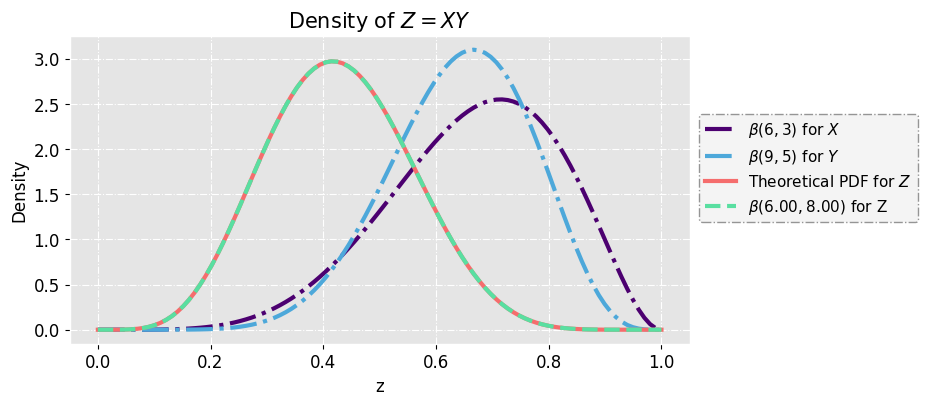

In [33]:
## 初始設定
# 設定參數
a1, b1, a2, b2 = 6, 3, 9, 5
# 設定 X, Y 的分配
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)
# 計算理論 Z 的 PDF
z = np.linspace(0, 1, 100)
def f(z):
    fxy = lambda y : fy(y) * fx(z / y) / y  # define the integrand: inline
    tmp = integrate.quad(fxy, z, 1)
    return tmp[0]
fz = np.vectorize(f)(z)  # z 如果是 array，就會自動對每個元素呼叫 f，並且返回一個 array


## 用另一個 Beta 分配 \beta(a,b) 來近似 Z 的分配
# 定義 LSM 函數
def est_beta_param(params):
    a, b = params
    beta_pdf = lambda z: beta.pdf(z, a, b)
    integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
    integral = integrate.quad(integrand, 0, 1)
    return integral[0]
# 初始值
initial = [6, 8]
# 設定邊界
bounds = [(0, np.inf), (0, np.inf)]
# 使用 minimize 來估計出參數
result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')
# 獲取估計的參數
a_hat, b_hat = result.x


## 畫圖
plt.style.use('ggplot')
fig = plt.figure(figsize=(8, 4))
plt.plot(z, fx(z), label = f'$\\beta({a1}, {b1})$ for $X$', linestyle = '-.', linewidth = 3
         , color = '#4c0070')
plt.plot(z, fy(z), label = f'$\\beta({a2}, {b2})$ for $Y$', linestyle = '-.', linewidth = 3
         , color = '#4da8da')
plt.plot(z, fz, label = f'Theoretical PDF for $Z$' , linewidth = 3, linestyle = '-'
         , color = '#F56D6D')
plt.plot(z, beta.pdf(z, a_hat, b_hat), label = f'$\\beta({a_hat:.2f}, {b_hat:.2f})$ for Z'
         , linewidth = 3, linestyle = '--', color = '#59DFA1')
plt.xlabel('z', fontsize = 12, color = 'black')
plt.ylabel('Density', fontsize = 12, color = 'black')
plt.title('Density of $Z = XY$', fontsize = 15, color = 'black')
plt.tick_params(axis = 'both', labelsize = 12, colors = 'black')
lgd = plt.legend(edgecolor = '#666666', prop = {'size': 11}, frameon = True \
                 , bbox_to_anchor = (1.38, 0.77))
lgd.get_frame().set_linestyle('-.')
lgd.get_frame().set_alpha(0.4)
lgd.get_frame().set_linewidth(1)
lgd.get_frame().set_edgecolor('black')
plt.grid(True, linestyle = '-.', color = 'white')
plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：從圖中可以看出，使用 LSM 近似得到的 Beta 分佈曲線與數學推導的理論 PDF 曲線完全重疊，說明該近似分佈可以很好地替代理論分佈。

**<font color=lightseagreen>結論</font>**：
- 實驗結果表明，通過 LSM 近似得到的 Beta 分佈與理論分佈完全一致，因此可以利用這種近似方法來替代元件 $X$ 與 $Y$ 結合形成的系統 $Z$ 的理論分佈，並將其表達為 Beta 分佈。

- 此外，實驗進一步說明，在估計由串聯方式組成的系統 $Z$ 的分佈時，無需直接通過數學推導計算理論分佈。相反，可以通過模擬實驗來估計一個與理論分佈相似的 Beta 分佈及其參數，從而降低探索此分佈的難度。因此，後續實驗將採用 MLE、MME 和 KDE 方法來直接估計分佈的參數，以驗證該方法的可行性。

<hr>

**<font color=indianred>Step 3</font>**：分別生成 $X$ 與 $Y$ 的隨機樣本，直接利用 $Z = XY$ 的關係去進行計算，獲得 $Z$ 的樣本。接著，分別使用「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」來估計出此樣本的 Beta 分佈參數值，並與 LSM 估計出的理論參數值進行比較，觀察其差異以及是否接近理論參數值，以選擇出最適合的參數估計方法。

In [35]:
## 定義 LSM
def LSM(a1, b1, a2, b2):
    """
    Input:
        a1 (float): The parameter 'alpha' of the first beta distribution.
        b1 (float): The parameter 'beta' of the first beta distribution.
        a2 (float): The parameter 'alpha' of the second beta distribution.
        b2 (float): The parameter 'beta' of the second beta distribution.
    Output:
        a_hat (float): The estimated parameter 'alpha' of the beta distribution that approximates Z.
        b_hat (float): The estimated parameter 'beta' of the beta distribution that approximates Z.
    """
    # 設定 X, Y 的分配
    fx = lambda x: beta.pdf(x, a1, b1)
    fy = lambda y: beta.pdf(y, a2, b2)

    def f(z):
        fxy = lambda y : fy(y) * fx(z / y) / y  # define the integrand: inline
        tmp = integrate.quad(fxy, z, 1)
        return tmp[0]

    # 用另一個貝他分配 \beta(a,b) 來近似 Z 的分配
    # 定義最小值函數
    def est_beta_param(params):
        a, b = params
        beta_pdf = lambda z: beta.pdf(z, a, b)
        integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
        integral = integrate.quad(integrand, 0, 1)
        return integral[0]

    # 初始值
    initial = [6, 8]
    # 設定邊界
    bounds = [(0, np.inf), (0, np.inf)]

    # 使用 minimize 來最小化目標函數
    result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')

    # 獲取估計的參數
    a_hat, b_hat = result.x
    return a_hat, b_hat

## 定義 MLE
# def MLE(Z):
#     # 定義負對數似然函數
#     def neg_log_likelihood(params):
#         a, b = params
#         return -np.sum(np.log(beta.pdf(Z, a, b)))

#     # 初始值
#     initial = [2, 2]

#     # 設定邊界
#     bnds = [(0, np.inf), (0, np.inf)]

#     # 使用 minimize 來最小化負對數似然函數
#     result = minimize(neg_log_likelihood, initial, bounds = bnds, method = 'L-BFGS-B')

#     # 獲取估計的參數
#     a_hat, b_hat = result.x
#     return a_hat, b_hat

def MLE(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution Z = x * y,
                           where x ~ Beta(a1, b1) and y ~ Beta(a2, b2).
    Output:
        a_hat (float): The maximum likelihood estimate for the shape parameter 'alpha' of the 
                       Beta distribution fitted to Z.
        b_hat (float): The maximum likelihood estimate for the shape parameter 'beta' of the 
                       Beta distribution fitted to Z.
    """
    a_hat, b_hat, _, _ = beta.fit(Z, floc = 0, fscale = 1, method = 'MLE')
    return a_hat, b_hat

## 定義 MME
def MME(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution Z = x * y,
                           where x ~ Beta(a1, b1) and y ~ Beta(a2, b2).
    Output:
        a_hat (float): The method of moments estimate for the shape parameter 'alpha' of the 
                       Beta distribution fitted to Z.
        b_hat (float): The method of moments estimate for the shape parameter 'beta' of the 
                       Beta distribution fitted to Z.
    """
    a_hat, b_hat, _, _ = beta.fit(Z, floc = 0, fscale = 1, method = 'MM')
    return a_hat, b_hat

def KDE(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution Z = x * y,
                           where x ~ Beta(a1, b1) and y ~ Beta(a2, b2).
    Output:
        a_hat (float): The estimated shape parameter 'alpha' of the Beta distribution that 
                       best fits the data based on the KDE.
        b_hat (float): The estimated shape parameter 'beta' of the Beta distribution that 
                       best fits the data based on the KDE.
    """
    # KDE 的 PDF 擬合
    kde = gaussian_kde(Z)
    
    # 定義目標函數：最小化 KDE 與 Beta 分佈的密度差異來近似 Z 的分佈
    def est_beta_param(params):
        a, b = params
        beta_pdf = lambda z: beta.pdf(z, a, b)
        integrand = lambda z: (kde(z) - beta_pdf(z)) ** 2
        integral = integrate.quad(integrand, 0, 1)
        return integral[0]
    # 初始值
    initial = [2, 2]
    # 設定邊界
    bounds = [(0, np.inf), (0, np.inf)]
    # 使用 minimize 來最小化目標函數
    result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')

    # 使用初始猜測值進行參數優化
    a_hat, b_hat = result.x
    return a_hat, b_hat

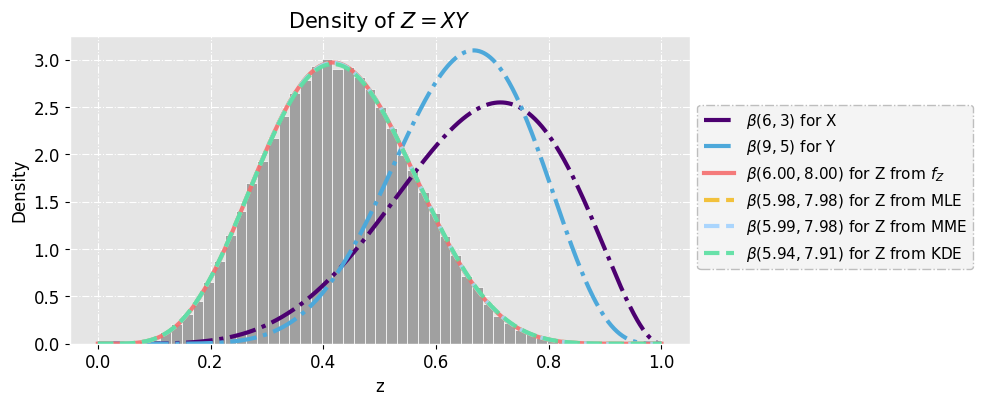

In [ ]:
# 設定參數
a1, b1, a2, b2 = 6, 3, 9, 5

# 設定 X, Y 的分配
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)

## 設定樣本
# 樣本數
n = 100000
# 生成來自 beta 分佈的樣本
x = beta.rvs(a1, b1, size = n)
y = beta.rvs(a2, b2, size = n)
Z = x * y

a_hat_lsm, b_hat_lsm = LSM(a1, b1, a2, b2)
a_hat_mle, b_hat_mle = MLE(Z)
a_hat_mme, b_hat_mme = MME(Z)
a_hat_kde, b_hat_kde = KDE(Z)


# 繪圖
z = np.linspace(0, 1, 1000)
fz_lsm = beta.pdf(z, a_hat_lsm, b_hat_lsm)
fz_mle = beta.pdf(z, a_hat_mle, b_hat_mle)
fz_mme = beta.pdf(z, a_hat_mme, b_hat_mme)
fz_kde = beta.pdf(z, a_hat_kde, b_hat_kde)

plt.style.use('ggplot')
fig = plt.figure(figsize = (8, 4))
plt.plot(z, fx(z), label = f'$\\beta({a1}, {b1})$ for X', linestyle = '-.', linewidth = 3
         , color = '#4c0070')
plt.plot(z, fy(z), label = f'$\\beta({a2}, {b2})$ for Y', linestyle = '-.', linewidth = 3
         , color = '#4da8da')
plt.plot(z, fz_lsm, label = f'$\\beta({a_hat_lsm:.2f}, {b_hat_lsm:.2f})$ for Z from $f_Z$' \
         , linewidth = 3, linestyle = '-', alpha = 0.9, color = '#F56D6D')
plt.plot(z, fz_mle, label = f'$\\beta({a_hat_mle:.2f}, {b_hat_mle:.2f})$ for Z from MLE' \
         , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#f4a261')
plt.plot(z, fz_mme, label = f'$\\beta({a_hat_mme:.2f}, {b_hat_mme:.2f})$ for Z from MME' \
         , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#a2d2ff')
plt.plot(z, fz_kde, label = f'$\\beta({a_hat_kde:.2f}, {b_hat_kde:.2f})$ for Z from KDE' \
        , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#59DFA1')

plt.hist(Z, bins = 45, density = True, color = '#A0A0A0' \
         , edgecolor = 'white')
plt.xlabel('z', fontsize = 12, color = 'black')
plt.ylabel('Density', fontsize = 12, color = 'black')
plt.title('Density of $Z = XY$', fontsize = 15, color = 'black')
plt.tick_params(axis = 'both', labelsize = 12, colors = 'black')
lgd = plt.legend(edgecolor = '#666666', prop = {'size': 11}, frameon = True \
                 , bbox_to_anchor = (1.47, 0.8))
lgd.get_frame().set_linestyle('-.')
lgd.get_frame().set_alpha(0.4)
lgd.get_frame().set_linewidth(1)
plt.grid(True, linestyle = '-.', color = 'white')
plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
- 從圖中可以看出，實驗分別使用 MLE、MME 和 KDE 三種方法來估計 Beta 分佈的參數。結果顯示，這三種方法估計出的參數值與通過 LSM 近似得到的理論參數值幾乎相同。

- 此外，系統 $Z$ 是由元件 $X$ 和 $Y$ 以串聯方式組成。在模擬中，系統 $Z$ 的可靠度顯著下降，其分佈曲線比元件 $X$ 和 $Y$ 的分佈曲線更右偏，表明壽命縮短。

**<font color=lightseagreen>結論</font>**：
- 實驗結果表明，MLE、MME 和 KDE 這三種參數估計方法在估計由串聯方式組成系統的分佈參數時表現良好。然而，目前尚無法確定它們是否能在其他類型的系統結構中同樣準確地估計分佈參數，如並聯結構，後續將進一步探討這一問題。

- 另外，實驗結果也顯示，串聯系統的可靠度比單一元件 $X$ 和 $Y$ 的可靠度更低，進而推斷串聯系統的壽命必然短於其組成元件的壽命。因此，僅使用串聯方式設計系統並非理想選擇。

<hr>
<hr>

### <strong><font color=cornflowerblue>目標二</font></strong>：
本目標想要估計出<font color=indianred>並聯元件</font>的 Beta 分佈參數，以下為實驗步驟：

假設一獨立變數：$X \sim \beta(a_1, b_1)$，若視 $Z$ 為兩個相同元件並聯後的可靠度，結合形成一新變數 $Z = 1 - (1 - X)^2$，推導後可得其機率密度函數 PDF 為
$$f_{Z}(z) = \frac{f_{X}(1 - \sqrt{1 - z})}{2\sqrt{1 - z}}$$

首先，本實驗想從理論上獲得由上述 $Z$ 的 PDF 近似出的另一個 Beta 分配 $\beta(a, b)$，並估計出其參數， 方法為下述的「最小平方法（LSM）」
$$ \min_{\substack{a, b > 0}} \int_{0}^{1} (f_{Z}(z) - \beta(z|a,b))^2 \; dz $$

令 $X$ 的 Beta PDF 的參數為 $(a_1, b_1)=(6, 3)$，利用上述方法估計出 $Z$ 的分佈參數 $a, b$。

$\quad$

此外，本實驗假設在無法透過數學推導獲得 $Z$ 的真實 PDF 的情況下，藉由生成 $X$ 與 $Y$ 的隨機樣本，並根據 $Z = 1 - (1 - X)^2$ 的關係進行計算，取得 $Z$ 的樣本。接著，分別使用「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」來估計這些樣本的 Beta 分佈參數值，並將結果與理論估計的參數值進行比較，以觀察其差異及與理論值的接近程度，從而選擇最適合的參數估計方法。

- MLE 在 Python 裡可使用的計算方式：
    - 使用 `scipy.optimize.minimize`；

    - 使用 `scipy.optimize.fmin`；

    - 使用 `scipy.stats.beta.fit`，其中 method = 'MLE'。

- MME 在 Python 裡可使用的計算方式：
    - 利用公式直接進行計算：
    $$ a = \bar{x}\left(\frac{\bar{x}(1 - \bar{x})}{s^2} - 1\right) $$
    $$ b = (1 - \bar{x})\left(\frac{\bar{x}(1 - \bar{x})}{s^2} - 1\right) $$

    - 使用 `scipy.stats.beta.fit`，其中 method = 'MM'。

- KDE 在 Python 裡可使用的計算方式：
    - 使用 `scipy.stats.gaussian_kde`。

$\quad$

並聯示意圖：

<p align="center">
  <img src="fig/parallel_conn.png" alt="Parallel Connection" width="300"/>
</p>    

**<font color=indianred>Step 1</font>**：由於在計算 LSM 時會使用 `scipy.optimize.minimize` 指令，其中 `method` 裡有許多不同的演算法可供選擇，每種方法的使用條件均不相同，故本實驗嘗試使用所有可用的演算法來進行 LSM 計算，並選出最合適、最快速的演算法來進行後續的實驗。

In [4]:
## 忽略特定类型的警告
warnings.filterwarnings("ignore")


## 初始設定
# 設定參數
a1, b1 = 6, 3
# 設定 X 的分配
fx = lambda x: beta.pdf(x, a1, b1)
# 計算理論 Z 的 PDF
# z = np.linspace(0, 1, 1000)
def f(z):
    if z == 1:
        return 0   # 這裡是因為在 z = 1 的時候，會出現 0/0 的情況
    return fx(1 - np.sqrt(1 - z)) / (2 * np.sqrt(1 - z))
# fz = np.vectorize(f)(z)  # z 如果是 array，就會自動對每個元素呼叫 f，並且返回一個 array


## 用另一個 Beta 分配 \beta(a,b) 來近似 Z 的分配
# 定義 LSM 函數
def est_beta_param(params):
    a, b = params
    beta_pdf = lambda z: beta.pdf(z, a, b)
    integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
    integral = integrate.quad(integrand, 0, 1)
    return integral[0]
# 初始值
initial = [8, 1]
# 設定邊界
bounds = [(0, np.inf), (0, np.inf)]


## 使用所有演算法來估計參數
methods = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr']
a_hat_avg = np.zeros(len(methods))
b_hat_avg = np.zeros(len(methods))
times_avg = np.zeros(len(methods))
# 重複計算 r 次
r = 10

# 使用多執行緒來加速計算
def run_method(method):
    a_hat = np.zeros(r)
    b_hat = np.zeros(r)
    times = np.zeros(r)

    for j in range(r):
        # 開始時間
        start_time = time.time()
        # 使用 minimize 來最小化目標函數
        result = minimize(est_beta_param, initial, bounds = bounds, method = method)
        # 結束時間
        end_time = time.time()
        # 獲取估計的參數
        a_hat[j], b_hat[j] = result.x
        times[j] = end_time - start_time

    # 取平均
    return np.mean(a_hat), np.mean(b_hat), np.mean(times)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(run_method, methods))

for i, (a_avg, b_avg, t_avg) in enumerate(results):
    a_hat_avg[i] = a_avg
    b_hat_avg[i] = b_avg
    times_avg[i] = t_avg


## 整理成表格呈現
algo_method = pd.DataFrame({
    'Method': methods,
    'a_hat_Avg': a_hat_avg,
    'b_hat_Avg': b_hat_avg,
    'Times_Avg(s)': times_avg
})
algo_method = algo_method.sort_values(by = 'Times_Avg(s)').reset_index(drop = True)

# 创建 Styler 对象并设置表格样式
styled_algo_method = algo_method.style.set_table_styles([
    {'selector': 'tr', 'props': [('border-top', '1px solid #666666')]},
    {'selector': 'tr', 'props': [('border-bottom', '1px solid #666666')]}
], overwrite=False)

# 显示样式化的 DataFrame
styled_algo_method

,Method,a_hat_Avg,b_hat_Avg,Times_Avg(s)
0,SLSQP,8.317821,1.221653,14.098622
1,L-BFGS-B,8.310614,1.221092,18.788700
2,COBYQA,8.310074,1.221086,25.058297
3,Powell,8.310058,1.221093,29.180968
4,TNC,7.821686,1.185444,31.811312
5,Nelder-Mead,8.310086,1.221083,33.825822
6,COBYLA,8.272594,1.218462,81.372301
7,trust-constr,8.310311,1.221103,84.049573


#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
與串聯系統的情況相同，在 `scipy.optimize.minimize` 指令中，部分演算法，如 `CG`, `BFGS`, `Newton-CG`, `dogleg`, `trust-ncg`, `trust-exact`, `trust-krylov` 無法用於本實驗。這是因為這些方法不支持邊界約束，而 Beta 分佈的參數 $a, b$ 需大於 0，因此構成了邊界約束（Boundary Constraint）。

**<font color=lightseagreen>結論</font>**：
- 從結果來看，大多數演算法在參數估計方面表現良好，估計出的參數值幾乎一致。然而，`TNC` 演算法的估計值與其他方法存在差異，表明它在此實驗中的參數估計表現較差，因此不適合作為後續實驗的方法。

- 在計算效率方面，`SLSQP` 所需時間最短，效率最高，而 `trust-constr` 所需時間最長。基於此，選擇 `SLSQP` 作為後續實驗的主要優化方法。

<hr>

**<font color=indianred>Step 2</font>**：根據上述的參數設定，畫出 $X$ 的分佈曲線，並利用推導出的 $Z$ 理論分佈，使用 LSM 來近似出 Beta 分佈，並畫出理論分佈曲線與 Beta 分佈曲線，觀察近似出的分佈表現與趨勢，並與理論分佈進行比較。

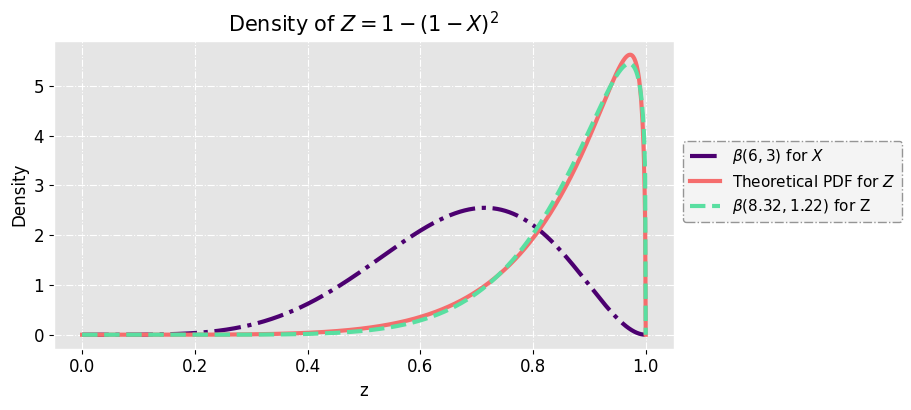

In [41]:
## 初始設定
# 設定參數
a1, b1 = 6, 3
# 設定 X 的分配
fx = lambda x: beta.pdf(x, a1, b1)
# 計算理論 Z 的 PDF
z = np.linspace(0, 1, 1000)
# f = lambda z : fx(1 - np.sqrt(1 - z)) / (2 * np.sqrt(1 - z))
def f(z):
    if z == 1:
        return 0   # 這裡是因為在 z = 1 的時候，會出現 0/0 的情況
    return fx(1 - np.sqrt(1 - z)) / (2 * np.sqrt(1 - z))
fz = np.vectorize(f)(z)  # z 如果是 array，就會自動對每個元素呼叫 f，並且返回一個 array


## 用另一個 Beta 分配 \beta(a,b) 來近似 Z 的分配
# 定義 LSM 函數
def est_beta_param(params):
    a, b = params
    beta_pdf = lambda z: beta.pdf(z, a, b)
    integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
    integral = integrate.quad(integrand, 0, 1)
    return integral[0]
# 初始值
initial = [8, 1]
# 設定邊界
bounds = [(0, np.inf), (0, np.inf)]
# 使用 minimize 來估計出參數
result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')
# 獲取估計的參數
a_hat, b_hat = result.x


## 畫圖
plt.style.use('ggplot')
fig = plt.figure(figsize = (8, 4))
plt.plot(z, fx(z), label = f'$\\beta({a1}, {b1})$ for $X$', linestyle = '-.', linewidth = 3
         , color = '#4c0070')
plt.plot(z, fz, label = f'Theoretical PDF for $Z$' , linewidth = 3, linestyle = '-'
         , color = '#F56D6D')
plt.plot(z, beta.pdf(z, a_hat, b_hat), label = f'$\\beta({a_hat:.2f}, {b_hat:.2f})$ for Z'
         , linewidth = 3, linestyle = '--', color = '#59DFA1')
plt.xlabel('z', fontsize = 12, color = 'black')
plt.ylabel('Density', fontsize = 12, color = 'black')
plt.title('Density of $Z = 1 - (1 - X)^2$', fontsize = 15, color = 'black')
plt.tick_params(axis = 'both', labelsize = 12, colors = 'black')
lgd = plt.legend(edgecolor = '#666666', prop = {'size': 11}, frameon = True \
                 , bbox_to_anchor = (1.38, 0.7))
lgd.get_frame().set_linestyle('-.')
lgd.get_frame().set_alpha(0.4)
lgd.get_frame().set_linewidth(1)
lgd.get_frame().set_edgecolor('black')
plt.grid(True, linestyle = '-.', color = 'white')
plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：從圖中可以看出，與串聯系統的情況不同，通過 LSM 近似得到的 Beta 分佈曲線與數學推導的理論 PDF 曲線之間存在些許差異，兩條曲線未完全重疊。但整體趨勢相似，表明該近似出的 Beta 分佈可用於替代理論分佈。

**<font color=lightseagreen>結論</font>**：
- 實驗結果表明，雖然 LSM 近似出的 Beta 分佈與理論分佈不完全一致，但在整體趨勢上高度相似。因此，可以採用該方法，將元件 $X$ 和 $Y$ 組成的系統 $Z$ 的分佈用 Beta 分佈來替代理論分佈。

- 此外，實驗還揭示了一個重要現象：在估計由並聯方式組成的系統 $Z$ 的分佈時，無需通過數學推導直接計算理論分佈，而是可以通過模擬實驗來估計出與理論分佈相似的 Beta 分佈參數，從而大幅降低推導分佈的難度。基於此，本實驗後續將採用 MLE、MME 和 KDE 方法直接估計該分佈的參數。

<hr>

**<font color=indianred>Step 3</font>**：生成 $X$ 的隨機樣本，直接利用 $Z = 1 - (1 - X)^2$ 的關係去進行計算，獲得 $Z$ 的樣本。接著，分別使用「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」來估計出此樣本的 Beta 分佈參數值，並與 LSM 估計出的理論參數值進行比較，觀察其差異以及是否接近理論參數值，以選擇出最適合的參數估計方法。

In [43]:
## 定義 LSM
def LSM(a1, b1):
    """
    Input:
        a1 (float): The parameter 'alpha' of the beta distribution.
        b1 (float): The parameter 'beta' of the beta distribution.
    Output:
        a_hat (float): The estimated parameter 'alpha' of the beta distribution that approximates Z.
        b_hat (float): The estimated parameter 'beta' of the beta distribution that approximates Z.
    """
    # 設定 X, Y 的分配
    fx = lambda x: beta.pdf(x, a1, b1)
    # 計算理論 Z 的 PDF
    # f = lambda z : fx(1 - np.sqrt(1 - z)) / (2 * np.sqrt(1 - z))
    def f(z):
        if z == 1:
            return 0   # 這裡是因為在 z = 1 的時候，會出現 0/0 的情況
        return fx(1 - np.sqrt(1 - z)) / (2 * np.sqrt(1 - z))

    # 用另一個貝他分配 \beta(a,b) 來近似 Z 的分配
    # 定義 LSM 函數
    def est_beta_param(params):
        a, b = params
        beta_pdf = lambda z: beta.pdf(z, a, b)
        integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
        integral = integrate.quad(integrand, 0, 1)
        return integral[0]
    # 初始值
    initial = [8, 1]
    # 設定邊界
    bounds = [(0, np.inf), (0, np.inf)]

    # 使用 minimize 來最小化目標函數
    result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')
    # 獲取估計的參數
    a_hat, b_hat = result.x
    return a_hat, b_hat

## 定義 MLE
def MLE(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution
                           Z = 1 - (1 - X)^2, where x ~ Beta(a1, b1).
    Output:
        a_hat (float): The maximum likelihood estimate for the shape parameter 'alpha' of the 
                       Beta distribution fitted to Z.
        b_hat (float): The maximum likelihood estimate for the shape parameter 'beta' of the 
                       Beta distribution fitted to Z.
    """
    a_hat, b_hat, _, _ = beta.fit(Z, floc = 0, fscale = 1, method = 'MLE')
    return a_hat, b_hat

## 定義 MME
def MME(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution
                           Z = 1 - (1 - X)^2, where x ~ Beta(a1, b1).
    Output:
        a_hat (float): The method of moments estimate for the shape parameter 'alpha' of the 
                       Beta distribution fitted to Z.
        b_hat (float): The method of moments estimate for the shape parameter 'beta' of the 
                       Beta distribution fitted to Z.
    """
    a_hat, b_hat, _, _ = beta.fit(Z, floc = 0, fscale = 1, method = 'MM')
    return a_hat, b_hat

def KDE(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution
                           Z = 1 - (1 - X)^2, where x ~ Beta(a1, b1).
    Output:
        a_hat (float): The estimated shape parameter 'alpha' of the Beta distribution that 
                       best fits the data based on the KDE.
        b_hat (float): The estimated shape parameter 'beta' of the Beta distribution that 
                       best fits the data based on the KDE.
    """    
    # KDE 的 PDF 擬合
    kde = gaussian_kde(Z)
    
    # 定義目標函數：最小化 KDE 與 Beta 分佈的密度差異來近似 Z 的分佈
    def est_beta_param(params):
        a, b = params
        beta_pdf = lambda z: beta.pdf(z, a, b)
        integrand = lambda z: (kde(z) - beta_pdf(z)) ** 2
        integral = integrate.quad(integrand, 0, 1)
        return integral[0]
    # 初始值
    initial = [2, 2]
    # 設定邊界
    bounds = [(0, np.inf), (0, np.inf)]
    # 使用 minimize 來最小化目標函數
    result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')

    # 使用初始猜測值進行參數優化
    a_hat, b_hat = result.x
    return a_hat, b_hat

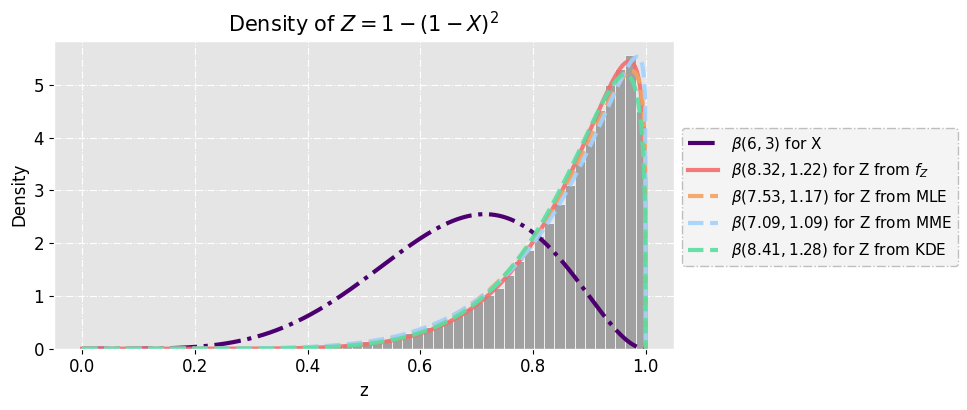

In [44]:
## 忽略特定类型的警告
warnings.filterwarnings("ignore")


# 設定參數
a1, b1 = 6, 3

# 設定 X, Y 的分配
fx = lambda x: beta.pdf(x, a1, b1)

## 設定樣本
# 樣本數
n = 100000
# 生成來自 beta 分佈的樣本
x = beta.rvs(a1, b1, size = n)
Z = 1 - (1 - x) ** 2

a_hat_lsm, b_hat_lsm = LSM(a1, b1)
a_hat_mle, b_hat_mle = MLE(Z)
a_hat_mme, b_hat_mme = MME(Z)
a_hat_kde, b_hat_kde = KDE(Z)


# 繪圖
z = np.linspace(0, 1, 1000)
fz_lsm = beta.pdf(z, a_hat_lsm, b_hat_lsm)
fz_mle = beta.pdf(z, a_hat_mle, b_hat_mle)
fz_mme = beta.pdf(z, a_hat_mme, b_hat_mme)
fz_kde = beta.pdf(z, a_hat_kde, b_hat_kde)

plt.style.use('ggplot')
fig = plt.figure(figsize = (8, 4))
plt.plot(z, fx(z), label = f'$\\beta({a1}, {b1})$ for X', linestyle = '-.', linewidth = 3
         , color = '#4c0070')
plt.plot(z, fz_lsm, label = f'$\\beta({a_hat_lsm:.2f}, {b_hat_lsm:.2f})$ for Z from $f_Z$' \
         , linewidth = 3, linestyle = '-', alpha = 0.9, color = '#F56D6D')
plt.plot(z, fz_mle, label = f'$\\beta({a_hat_mle:.2f}, {b_hat_mle:.2f})$ for Z from MLE' \
         , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#f4a261')
plt.plot(z, fz_mme, label = f'$\\beta({a_hat_mme:.2f}, {b_hat_mme:.2f})$ for Z from MME' \
         , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#a2d2ff')
plt.plot(z, fz_kde, label = f'$\\beta({a_hat_kde:.2f}, {b_hat_kde:.2f})$ for Z from KDE' \
        , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#59DFA1')

plt.hist(Z, bins = 45, density = True, color = '#A0A0A0' \
         , edgecolor = 'white')
plt.xlabel('z', fontsize = 12, color = 'black')
plt.ylabel('Density', fontsize = 12, color = 'black')
plt.title('Density of $Z = 1 - (1 - X)^2$', fontsize = 15, color = 'black')
plt.tick_params(axis = 'both', labelsize = 12, colors = 'black')
lgd = plt.legend(edgecolor = '#666666', prop = {'size': 11}, frameon = True \
                 , bbox_to_anchor = (1.47, 0.74))
lgd.get_frame().set_linestyle('-.')
lgd.get_frame().set_alpha(0.4)
lgd.get_frame().set_linewidth(1)
plt.grid(True, linestyle = '-.', color = 'white')
plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
- 從圖中可以看出，本實驗分別使用 MLE、MME 和 KDE 三種方法來估計 Beta 分佈的參數。其中，MLE 和 MME 所估計的參數值與由 LSM 近似得出的理論參數值略有差異，但相當接近。從圖形比較可以發現，它們與理論 PDF 曲線的整體形狀差異不大。相比之下，KDE 所估計的參數值幾乎與理論參數值完全相同，表現更為優異。

- 此外，元件 $X$ 與 $Y$ 以並聯方式組成的系統 $Z$ 在模擬中呈現可靠度上升的趨勢，從圖中可以明顯觀察到 $Z$ 的分佈曲線相較於 $X$ 和 $Y$ 更加左偏。

**<font color=lightseagreen>結論</font>**：
- 實驗結果表明，KDE 在參數估計方面的表現優於 MLE 和 MME。這裡需要說明的是，實驗中使用 KDE 的估計方式是先以資料擬合出 KDE 的 PDF，再利用 LSM 近似出與 KDE 的 PDF 相似的 Beta 分佈。由於該過程與基於數學推導的理論 PDF 方法相似，因此只要 KDE 擬合出的分佈與理論分佈接近，此方法在參數估計上的表現就會更佳。

- 總體而言，MLE、MME 和 KDE 三種方法均適用於並聯系統的分佈參數估計，但其中以 KDE 的表現最佳。

- 此外，實驗結果還顯示，以並聯方式連接的系統，其可靠度顯著高於單一元件 $X$ 和 $Y$。因此，可以推斷並聯系統的壽命通常會超過其組成元件的壽命，這種設計在可靠度提升方面具有理想效果。

<hr>
<hr>

### <strong><font color=cornflowerblue>目標三</font></strong>：
本目標想要結合前面串聯與並聯的情況，估計出<font color=indianred>串並聯元件</font>的 Beta 分佈參數，以下為實驗步驟：

假設三獨立變數：$W \sim \beta(a_1, b_1)$，$X \sim \beta(a_2, b_2)$，$Y \sim \beta(a_3, b_3)$，結合可形成一新變數 $Z$，分別設計兩種不同的系統，

第一種系統為<font color=indianred>先串聯後並聯</font>：
$$Z_1 = 1 - (1 - (WXY)) ^ 2$$

第二種系統為<font color=indianred>先並聯後串聯</font>：
$$Z_2 = (1 - (1 - W) ^ 2)(1 - (1 - X) ^ 2)(1 - (1 - Y) ^ 2)$$


但是，由於 $Z_1$, $Z_2$ 都是包含三種變數的非線性組合，故其分佈無法像前兩目標一樣直接推導出封閉形式的機率密度函數，只能在無法通過數學推導來獲得 $Z_1$, $Z_2$ 的真實 PDF 的情況下利用模擬計算的方式來估計出 $Z_1$, $Z_2$ 的分佈。

$\quad$

令 $W$, $X$, $Y$ 的 Beta PDF 的參數分別為 $(a_1, b_1)=(6, 3), (a_2, b_2)=(9, 5), (a_3, b_3)=(7, 4)$，通過分別生成 $W$, $X$ 與 $Y$ 的隨機樣本，直接去進行計算，獲得 $Z_1$, $Z_2$ 的樣本。接著，分別使用「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」來估計出此樣本的 Beta 分佈參數值，通過相互比較來選擇出最適合的參數估計方法。

- MLE 在 Python 裡可使用的計算方式：
    - 使用 `scipy.optimize.minimize`；

    - 使用 `scipy.optimize.fmin`；

    - 使用 `scipy.stats.beta.fit`，其中 method = 'MLE'。

- MME 在 Python 裡可使用的計算方式：
    - 利用公式直接進行計算：
    $$ a = \bar{x}\left(\frac{\bar{x}(1 - \bar{x})}{s^2} - 1\right) $$
    $$ b = (1 - \bar{x})\left(\frac{\bar{x}(1 - \bar{x})}{s^2} - 1\right) $$

    - 使用 `scipy.stats.beta.fit`，其中 method = 'MM'。

- KDE 在 Python 裡可使用的計算方式：
    - 使用 `scipy.stats.gaussian_kde`。

$\quad$

串並聯示意圖：

<!-- <p align="center">
  <img src="fig/series_parallel_conn.png" alt="Series Connection" width="500"/>
</p> -->

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 1; text-align: center;">
    <img src="fig/series_parallel_conn_z1.png" alt="Series and Parallel Connection 1" width="500"/>
    <p>圖 1</p>
  </div>
  <div style="flex: 1; text-align: center;">
    <img src="fig/series_parallel_conn_z2.png" alt="Series and Parallel Connection 2" width="500"/>
    <p>圖 2</p>
  </div>
</div>

根據上述的參數設定，分別畫出 $W$, $X$ 與 $Y$ 的分佈曲線。接著，分別生成 $W$, $X$ 與 $Y$ 的隨機樣本，直接去進行計算，獲得 $Z$ 的樣本。接著，分別使用「最大概似估計（MLE）」、「動差估計（MME）」及「核密度估計（KDE）」來估計出此樣本的 Beta 分佈參數值，並觀察與比較三種方法計算出的參數值差異，以及觀察與樣本直方圖的吻合程度，進而判斷估計的可信度與選出最適合的估計方法。

In [2]:
## 定義 MLE
def MLE(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution Z1 or Z2,
                           where w ~ Beta(a1, b1), x ~ Beta(a2, b2) and y ~ Beta(a3, b3).
    Output:
        a_hat (float): The maximum likelihood estimate for the shape parameter 'alpha' of the 
                       Beta distribution fitted to Z.
        b_hat (float): The maximum likelihood estimate for the shape parameter 'beta' of the 
                       Beta distribution fitted to Z.
    """    
    a_hat, b_hat, _, _ = beta.fit(Z, floc = 0, fscale = 1, method = 'MLE')
    return a_hat, b_hat

## 定義 MME
def MME(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution Z1 or Z2,
                           where w ~ Beta(a1, b1), x ~ Beta(a2, b2) and y ~ Beta(a3, b3).
    Output:
        a_hat (float): The method of moments estimate for the shape parameter 'alpha' of the 
                       Beta distribution fitted to Z.
        b_hat (float): The method of moments estimate for the shape parameter 'beta' of the 
                       Beta distribution fitted to Z.
    """    
    a_hat, b_hat, _, _ = beta.fit(Z, floc = 0, fscale = 1, method = 'MM')
    return a_hat, b_hat

def KDE(Z):
    """
    Input:
        Z (numpy.ndarray): A numpy array of size (N,) containing samples from the distribution Z1 or Z2,
                           where w ~ Beta(a1, b1), x ~ Beta(a2, b2) and y ~ Beta(a3, b3).
    Output:
        a_hat (float): The estimated shape parameter 'alpha' of the Beta distribution that 
                       best fits the data based on the KDE.
        b_hat (float): The estimated shape parameter 'beta' of the Beta distribution that 
                       best fits the data based on the KDE.
    """        
    # KDE 的 PDF 擬合
    kde = gaussian_kde(Z)
    
    # 定義目標函數：最小化 KDE 與 Beta 分佈的密度差異來近似 Z 的分佈
    def est_beta_param(params):
        a, b = params
        beta_pdf = lambda z: beta.pdf(z, a, b)
        integrand = lambda z: (kde(z) - beta_pdf(z)) ** 2
        integral = integrate.quad(integrand, 0, 1)
        return integral[0]
    # 初始值
    initial = [2, 2]
    # 設定邊界
    bounds = [(0, np.inf), (0, np.inf)]
    # 使用 minimize 來最小化目標函數
    result = minimize(est_beta_param, initial, bounds = bounds , method = 'SLSQP')

    # 使用初始猜測值進行參數優化
    a_hat, b_hat = result.x
    return a_hat, b_hat

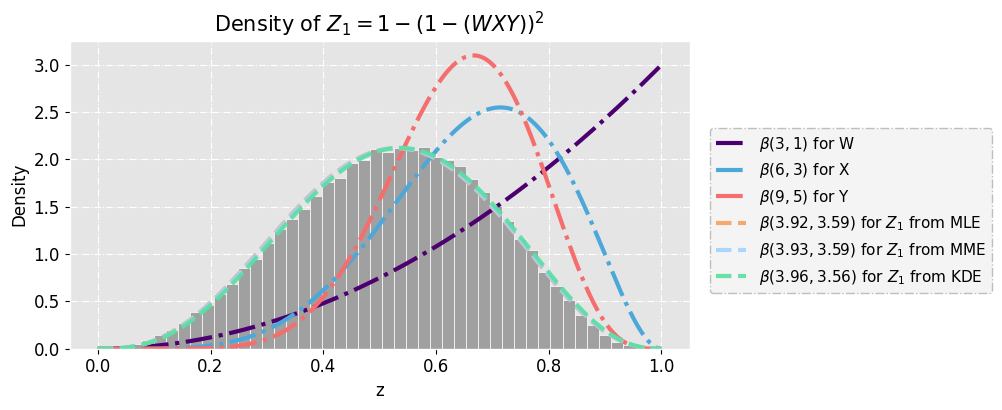

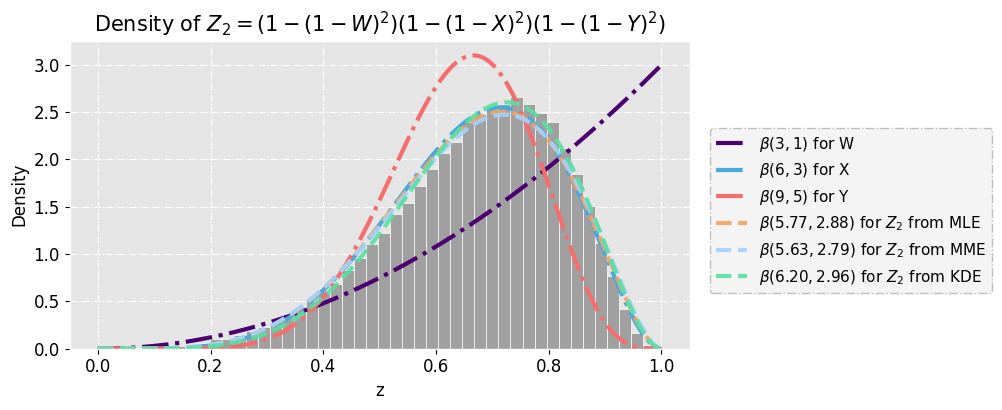

In [3]:
## 忽略特定类型的警告
warnings.filterwarnings("ignore")


## 設定參數
a1, b1, a2, b2, a3, b3 = 3, 1, 6, 3, 9, 5

# 設定 X, Y 的分配
fw = lambda w: beta.pdf(w, a1, b1)
fx = lambda x: beta.pdf(x, a2, b2)
fy = lambda y: beta.pdf(y, a3, b3)


## 設定樣本
# 樣本數
n = 100000
# 生成來自 beta 分佈的樣本
w = beta.rvs(a1, b1, size = n)
x = beta.rvs(a2, b2, size = n)
y = beta.rvs(a3, b3, size = n)
Z1 = 1 - (1 - (w * x * y)) ** 2
Z2 = (1 - (1 - w) ** 2) * (1 - (1 - x) ** 2) * (1 - (1 - y) ** 2)


## 同時畫出兩個圖
Z = [Z1, Z2]
Z_txt = ['$Z_1$', '$Z_2$']
for i in range(len(Z)):
    # 估計參數
    a_hat_mle, b_hat_mle = MLE(Z[i])
    a_hat_mme, b_hat_mme = MME(Z[i])
    a_hat_kde, b_hat_kde = KDE(Z[i])

    # 畫圖
    z = np.linspace(0, 1, 1000)
    fz_mle = beta.pdf(z, a_hat_mle, b_hat_mle)
    fz_mme = beta.pdf(z, a_hat_mme, b_hat_mme)
    fz_kde = beta.pdf(z, a_hat_kde, b_hat_kde)
    if i == 0:
        title = 'Density of $Z_1 = 1 - (1 - (WXY))^2$'
    else:
        title = 'Density of $Z_2 = (1 - (1 - W)^2)(1 - (1 - X)^2)(1 - (1 - Y)^2)$'

    plt.style.use('ggplot')
    fig = plt.figure(figsize = (8, 4))

    plt.plot(z, fw(z), label = f'$\\beta({a1}, {b1})$ for W', linestyle = '-.', linewidth = 3
            , color = '#4c0070')
    plt.plot(z, fx(z), label = f'$\\beta({a2}, {b2})$ for X', linestyle = '-.', linewidth = 3
            , color = '#4da8da')
    plt.plot(z, fy(z), label = f'$\\beta({a3}, {b3})$ for Y', linestyle = '-.', linewidth = 3
            , color = '#F56D6D')
    plt.plot(z, fz_mle, label = f'$\\beta({a_hat_mle:.2f}, {b_hat_mle:.2f})$ for {Z_txt[i]} from MLE' \
            , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#f4a261')
    plt.plot(z, fz_mme, label = f'$\\beta({a_hat_mme:.2f}, {b_hat_mme:.2f})$ for {Z_txt[i]} from MME' \
            , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#a2d2ff')
    plt.plot(z, fz_kde, label = f'$\\beta({a_hat_kde:.2f}, {b_hat_kde:.2f})$ for {Z_txt[i]} from KDE' \
            , linewidth = 3, linestyle = '--', alpha = 0.9, color = '#59DFA1')
    
    plt.hist(Z[i], bins = 45, density = True, color = '#A0A0A0', edgecolor = 'white')
    plt.xlabel('z', fontsize = 12, color = 'black')
    plt.ylabel('Density', fontsize = 12, color = 'black')
    plt.title(title, fontsize = 15, color = 'black')
    plt.tick_params(axis = 'both', labelsize = 12, colors = 'black')
    lgd = plt.legend(edgecolor = '#666666', prop = {'size': 11}, frameon = True \
                    , bbox_to_anchor = (1.5, 0.74))
    lgd.get_frame().set_linestyle('-.')
    lgd.get_frame().set_alpha(0.4)
    lgd.get_frame().set_linewidth(1)
    plt.grid(True, linestyle = '-.', color = 'white')
    plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
- <font color=indianred>先串聯後並聯</font>的系統 $Z_1$：
    - 從圖中可見，三種方法（MLE、MME、KDE）估計的參數值差異不大，且它們繪製出的 PDF 曲線均涵蓋了樣本直方圖的範圍，顯示這三種方法在參數估計上的表現相當不錯。

    - 此外，元件 $W$、$X$ 和 $Y$ 以先串聯後並聯的方式組成的系統 $Z_1$，在模擬中顯示可靠度下降的趨勢。從圖中可以觀察到，無論使用哪種方法估計，$Z_1$ 的分佈曲線相較於 $W$、$X$ 和 $Y$ 更加右偏。

- <font color=indianred>先並聯後串聯</font>的系統 $Z_2$：
    - 從圖中可見，MLE 和 MME 所估計的參數值非常接近，但與 KDE 存在一定差異。然而，從圖形比較可以發現，由 KDE 所估計的分佈曲線與樣本直方圖更為貼合，因此可判定 KDE 在參數估計方面的表現優於其他兩種方法。

    - 此外，元件 $W$, $X$ 與 $Y$ 以先並聯後串聯的方式組成的系統 $Z_2$，模擬結果顯示其可靠度與單一元件 $Y$ 相比差異不大。圖中可以明顯看出，無論使用哪種方法估計，$Z_2$ 的分佈曲線介於 $W$, $X$ 與 $Y$ 的分佈之間，並且與可靠度居中的元件 $Y$ 的分佈更為接近。

**<font color=lightseagreen>結論</font>**：
- 實驗結果表明，MLE、MME 和 KDE 均適用於估計以串並聯方式組成系統的分佈參數，特別是 KDE 的表現更為突出。

- 此外，實驗結果顯示，先並聯後串聯的系統可靠度高於先串聯後並聯的系統，這也意味著先並聯後串聯的系統壽命更長。因此，在設計系統組成方式時，應優先採用先並聯後串聯的組成方式。

<hr>
<hr>

### <strong><font color=lightseagreen>附錄</font></strong>：



**1. 串聯系統的變數與機率密度函數的推導過程**

- 變數的推導邏輯：

    在串聯系統中，假設兩個元件的可靠度分別為 $X$ 和 $Y$，它們遵循獨立的 **Beta** 分佈：
    $$X \sim \beta(a_1, b_1)，Y \sim \beta(a_2, b_2)$$
    串聯系統的可靠度 $Z$ 定義為兩元件可靠度的乘積：
    $$Z = X \cdot Y$$
    這是因為在串聯系統中，若任意一個元件失效，系統即失效。因此，系統的可靠度等於所有元件可靠度的乘積。

$\quad$

- 機率密度函數的推導過程：

    已知  $X \sim \beta(a_1, b_1)$，$Y \sim \beta(a_2, b_2)$，建立新變數 $Z = XY$，並引入輔助變數 $V = Y$

    1. $Z$ 的 **Support**：
    
        已知 $0 < x < 1$，$0 < y < 1$，其中 $Y$ 為固定值（**Fixed Value**），$Y = V = v$，推得
        $$\begin{align*} 0 < xy < y < 1 \Rightarrow 0 < z < v < 1 \end{align*}$$

    2. **Jacobian** 計算：

        已知 $X = \frac{Z}{Y}，Y = V$，推得

        - $\large \frac{\partial x}{\partial z} = \frac{\partial}{\partial z}(\frac{z}{y}) = \frac{1}{y}$

        - $\large \frac{\partial x}{\partial v} = \frac{\partial}{\partial v}(\frac{z}{y}) = \frac{\partial}{\partial v}(\frac{z}{v}) = -\frac{z}{v^2}$

        - $\large \frac{\partial y}{\partial z} = \frac{\partial}{\partial z}(v) = 0$

        - $\large \frac{\partial y}{\partial v} = \frac{\partial}{\partial v}(v) = 1$

        $$
        \begin{align*}
        J &= \frac{\partial x}{\partial z} \cdot \frac{\partial y}{\partial v} - \frac{\partial y}{\partial z} \cdot \frac{\partial x}{\partial v} \\
        &= \left(\frac{1}{y} \cdot 1\right) - \left(0 \cdot -\frac{z}{v^2}\right) \\
        &= \frac{1}{y}
        \end{align*}
        $$

    3. 建立 **Joint PDF** $f_{Z, V}(z, v)$：
        $$
        \begin{align*}
        f_{Z, V}(z, v) &= f_{X, Y}\left(\frac{z}{y}, y\right)\left|J\right| \\
        &= f_{X}\left(\frac{z}{y}\right)f_Y(y) \cdot \frac{1}{y} \\
        \end{align*}
        $$
        其中 $X \perp Y \Rightarrow f_{X, Y}(x, y) = f_X(x)f_Y(y)$。

        推導出 $Z$ 的 **Marginal PDF**：
        $$
        \begin{align*}
        f_{Z}(z) &= \int_z^1 f_X\left(\frac{z}{y}\right)f_{Y}(y) \cdot \frac{1}{y} dy \\
        \end{align*}
        $$


---

**2. 並聯系統的變數與機率密度函數的推導過程**

- 變數的推導邏輯：

    在並聯系統中，假設元件的可靠度 $X$ 遵循獨立的 **Beta** 分佈：
    $$X \sim \beta(a_1, b_1)$$
    並聯系統的可靠度 $Z$ 定義為系統中至少一個元件運行正常的概率。由於並聯系統中，只要其中一個元件正常運作，整個系統即可運作，因此 $Z$ 為
    $$Z = 1 - (1 - X)^2$$

    推導邏輯：
    1. $1 - X$ 表示單個元件失效的概率。

    2. $(1 - X)^2$ 表示在假設兩元件彼此獨立下，兩個並聯元件同時失效的概率。

    3. 並聯系統的可靠度等於 1 減去所有元件同時失效的概率，因此
    $$Z = 1 - (1 - X)^2$$

$\quad$

- 機率密度函數的推導過程：

    已知 $X \sim \beta(a_1, b_1)$，建立新變數 $Z = 1 - (1 - X)^2$

    1. $Z$ 轉換成 $X$：
    
    $$
    \begin{align*}
    Z &= 1 - (1 - X)^2 \\
    \Rightarrow 1 - Z &= (1 - X)^2 \\
    \Rightarrow \sqrt{1 - Z} &= 1 - X \\
    \Rightarrow X &= 1 - \sqrt{1 - Z}
    \end{align*}
    $$

    2. **Jacobian** 計算：
        $$
        \begin{align*}
        \frac{dx}{dz} &= \frac{d}{dz}(1 - \sqrt{1 - z}) \\
        &= -\frac{1}{2}\frac{1}{\sqrt{1 - z}} \cdot -1 \\
        &= \frac{1}{2\sqrt{1 - z}}
        \end{align*}
        $$

    3. 建立 $f_{Z}(z)$：
        $$
        \begin{align*}
        f_{Z}(z) &= f_X(1 - \sqrt{1 - z})\left|\frac{dx}{dz}\right| \\
        &= f_X(1 - \sqrt{1 - z})\left|\frac{1}{2\sqrt{1 - z}}\right| \\
        &= \frac{f_X(1 - \sqrt{1 - z})}{2\sqrt{1 - z}} \\
        \end{align*}
        $$

---